# Getting started with Lance for computer vision

Lance is a columnar data format that is an alternative to Parquet for computer vision data. Lance makes working with visual datasets much easier and faster than before. In this tutorial, we'll go through a simple workflow showing you how to explore using pytorch/arrow backed by Lance datasets.

Lance is free and open-source:

Github: https://github.com/eto-ai/lance <br>
Docs: https://lance.readthedocs.io/en/latest/ <br>
This notebook: https://github.com/eto-ai/lance/tree/main/python/notebooks/quickstart.ipynb

## Pre-requisites

With python 3.10 installed on Mac or Linux (windows support forthcoming), let's setup a virtual environment (avoid Conda for now due to libc conflict):

```bash
python -m venv ~/.venv/lance
source ~/.venv/lance/bin/activate
pip install pylance duckdb pandas pillow matplotlib
```

In [1]:
import lance
lance.__version__

'0.0.5'

In [2]:
import os

import duckdb
import pandas as pd
import pyarrow as pa
import pyarrow.compute as pc

from lance.types import Image

db = duckdb.connect()

## Working with Lance datasets

With Lance's python wrapper, we can easily read/write Arrow tables in Lance format. Let's take a look at a copy of the Oxford Pet dataset that we've already converted to Lance format.

In [3]:
uri = "s3://eto-public/datasets/oxford_pet/oxford_pet.lance"
ds = lance.dataset(uri)
ds.schema.names

['filename',
 'class',
 'species',
 'breed',
 'split',
 'folder',
 'source',
 'size',
 'segmented',
 'object',
 'image']

## Explore your vision datasets with sub-second performance

It's easy to explore vision data via Lance's Arrow integration. For example, we can use duckdb to compute things like label distribution

In [4]:
%%time
df = db.query(("SELECT class, count(1) "
               "FROM ds "
               "WHERE split='val'"
               "GROUP BY 1")).to_df()
df.head()

CPU times: user 12.8 ms, sys: 8.96 ms, total: 21.8 ms
Wall time: 225 ms


,class,count(1)
0,Abyssinian,50
1,american_bulldog,50
2,american_pit_bull_terrier,50
3,basset_hound,50
4,beagle,50


Not bad! We get sub-second performance here on remote data stored on S3. <br>
Doing this on the raw dataset (txt index + xml annotations) is roughly 50-100x slower.

## Slice-and-dice-and-visualize 

I love smiling sammies, so let's see some Samoyeds

In [5]:
%%time

df = db.query("SELECT image "
              "FROM ds "
              "WHERE class='samoyed' "
              "LIMIT 10").to_df()
Image.create(df.image[0])

CPU times: user 122 ms, sys: 43.1 ms, total: 165 ms
Wall time: 4.34 s


Image(<embedded>)

## Lance is fast!

Doing similar analytics queries on Lance is 50-10x faster than on the raw dataset (not to mention very little code by comparison)

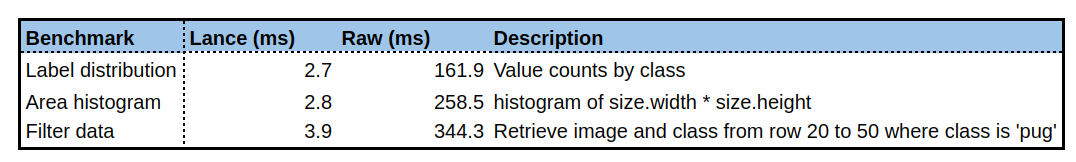

With parquet you tradeoff scan vs random access performance by tuning the row_group_size. With Lance, you can have your cake and eat it too. Take a look at the performance of Lance vs Parquet below ([benchmark code](https://github.com/eto-ai/lance/blob/main/python/benchmarks/coco/analytics.py))

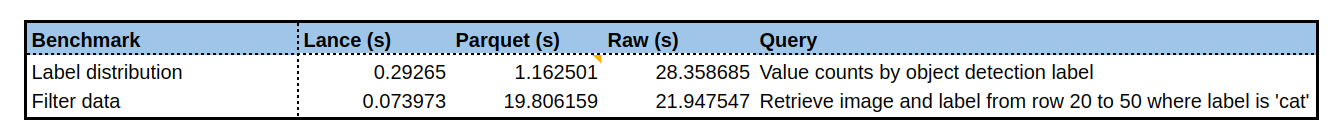

## Inference

Lance comes with a Pytorch dataset so it's super easy to extract insights from vision data

In [6]:
import multiprocessing as mp

import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
from torchvision.utils import draw_bounding_boxes

from lance.pytorch.data import LanceDataset

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    n_pred = 128
else:
    device = torch.device("cpu")
    n_pred = 12

print(device)

cuda:0


Used pre-trained model

In [8]:
# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()
model.to(device)


# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

Create a data loader

In [64]:
uri = "/mnt/lance/code/eto/lance/python/notebooks/datasets/coco/coco.lance"
val_ds = LanceDataset(uri, columns=["image"],
                      filter=pc.field("split") == "test",
                      transform=lambda img, split: preprocess(img),
                      batch_size=64)

val_loader = DataLoader(
    val_ds,
    num_workers=mp.cpu_count()-1,
    collate_fn=lambda batch: batch,
)

Run the inference

In [66]:
%%time

def extract_pred(pred):    
    label_ids = pred["labels"].cpu().detach().numpy().astype(int)
    labels = [weights.meta["categories"][i] for i in label_ids]
    boxes = pred["boxes"].cpu().detach().numpy().astype('double')
    return to_pil_image(batch[0]), labels, boxes    

data = []
for i, batch in enumerate(val_loader):
    with torch.no_grad():
        batch = [r.to(device) for r in batch]
        data.extend([extract_pred(pred) for pred in model(batch)])    
    if len(data) > n_pred:
        break

CPU times: user 6.64 s, sys: 683 ms, total: 7.32 s
Wall time: 7.93 s


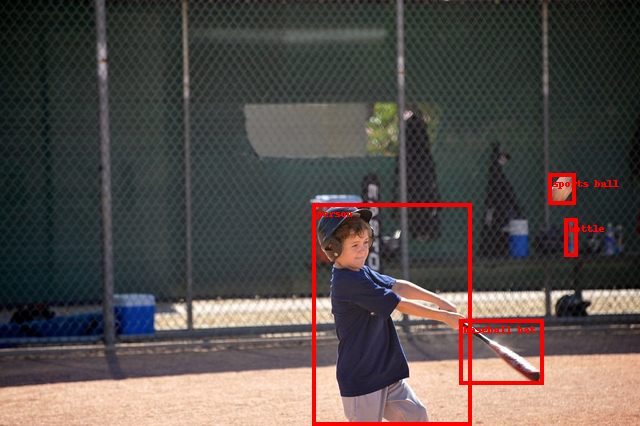

In [70]:
to_pil_image(draw_bounding_boxes(pil_to_tensor(data[0][0]),
                                 boxes=torch.from_numpy(data[0][2]),
                                 labels=data[0][1],
                                 colors="red",
                                 width=4))

### Insights

Using the predicted labels, it's easy to get a distribution of what's in these images

In [72]:
(pd.Series([d[1] for d in data])
 .explode()
 .value_counts()
 .head(10))

person         279
cup             58
bottle          43
car             34
chair           32
kite            28
pizza           26
vase            18
sports ball     15
surfboard       14
dtype: int64

## Conclusion

In under one minute we were able to explore two different CV datasets stored on S3. Lance makes it really easy to explore large collections of images.

## Roadmap

The Lance roadmap is chock-full of exciting features:

1. Data versioning and schema evolution (update annotations, snapshot new model results, etc)
2. CV/ML indexing support (vector indices, inverted index)
3. Rich media type support (images, videos, 3d point clouds, pdfs, audio, and more)

## We value your feedback

If you have questions, feature requests, or bug reports, please don't hesitate to:

1. File a github issue: https://github.com/eto-ai/lance/issues
OR
2. Send us an email contact@eto.ai

We'd love to hear from you